In [ ]:
!git clone https://github.com/janedoesrepo/Autoencoder-ImbalancedCreditData.git

In [ ]:
!unzip /content/Autoencoder-ImbalancedCreditData/data/creditcard.zip

In [ ]:
#import the required library
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import det_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
# Load the dataset
df = pd.read_csv("/content/creditcard.csv")
df.sample(10)

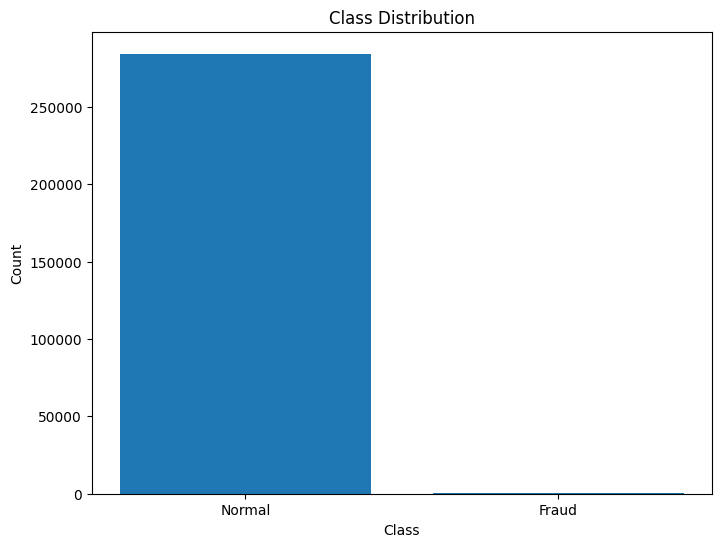

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Count the occurrences of each class
class_counts = df['Class'].value_counts()

# Create a list of class labels
labels = ['Normal', 'Fraud']

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(labels, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
class_distribution = df['Class'].value_counts()

print(class_distribution)

Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
# Extract normal transactions (Class == 0)
normal_transactions = df[df["Class"] == 0]
fruad_transactions = df[df["Class"] == 1]
normal_transactions=normal_transactions.drop('Class', axis=1)

# Split the data into train and test sets
X_train, X_test = train_test_split(normal_transactions, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Define the autoencoder model
input_dim = X_train_scaled.shape[1]
encoding_dim = 20

input_layer = Input(shape=(input_dim,))
l1= Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder_layer = Dense(encoding_dim, activation="relu")(l1)
l2= Dense(100, activation="relu")(encoder_layer)
decoder_layer = Dense(input_dim, activation="linear")(l2)

autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

# Compile the model
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with checkpoint and early stopping
history = autoencoder.fit(X_train_scaled, X_train_scaled, epochs=100, batch_size=64, shuffle=False,
                          validation_data=(X_test_scaled, X_test_scaled), callbacks=[checkpoint, early_stopping])
# Evaluate the model on the test set
test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled)
print(f"Test loss: {test_loss:.4f}")


Epoch 1/100
3527/3554 [============================>.] - ETA: 0s - loss: 0.1314
Epoch 1: val_loss improved from inf to 0.04938, saving model to best_model.h5
3554/3554 [==============================] - 10s 3ms/step - loss: 0.1309 - val_loss: 0.0494
Epoch 2/100
  85/3554 [..............................] - ETA: 6s - loss: 0.0446

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3543/3554 [============================>.] - ETA: 0s - loss: 0.0411
Epoch 2: val_loss improved from 0.04938 to 0.02969, saving model to best_model.h5
3554/3554 [==============================] - 7s 2ms/step - loss: 0.0411 - val_loss: 0.0297
Epoch 3/100
3528/3554 [============================>.] - ETA: 0s - loss: 0.0285
Epoch 3: val_loss improved from 0.02969 to 0.02133, saving model to best_model.h5
3554/3554 [==============================] - 9s 2ms/step - loss: 0.0285 - val_loss: 0.0213
Epoch 4/100
3535/3554 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 4: val_loss improved from 0.02133 to 0.01727, saving model to best_model.h5
3554/3554 [==============================] - 9s 2ms/step - loss: 0.0229 - val_loss: 0.0173
Epoch 5/100
3550/3554 [============================>.] - ETA: 0s - loss: 0.0201
Epoch 5: val_loss improved from 0.01727 to 0.01599, saving model to best_model.h5
3554/3554 [==============================] - 8s 2ms/step - loss: 0.0201 - val_loss: 0.0160


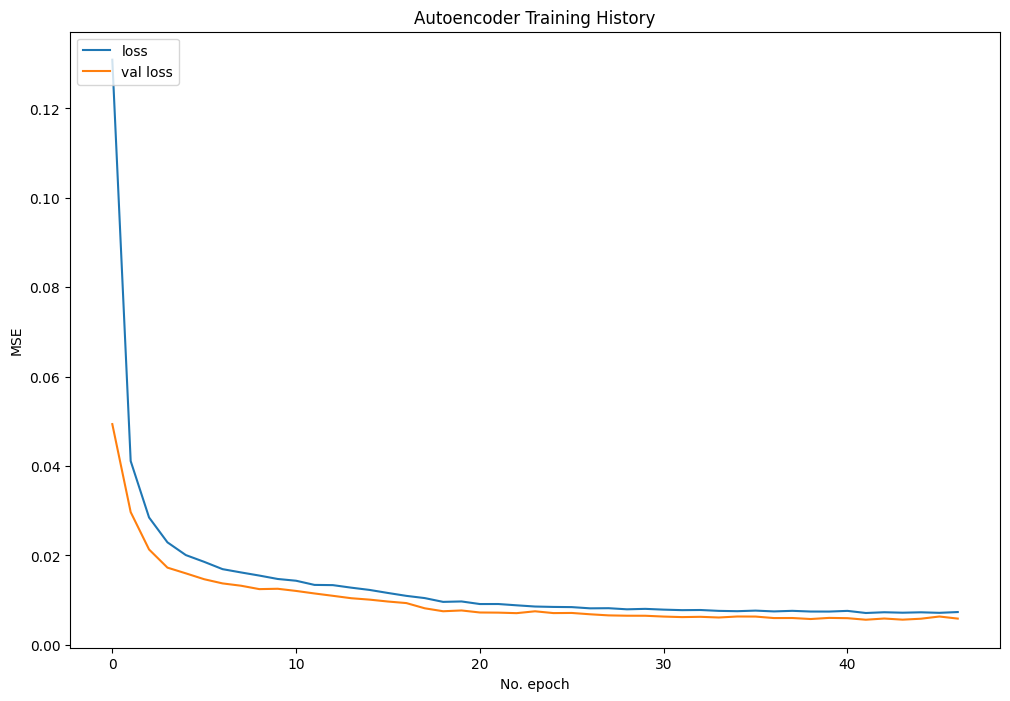

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title("Autoencoder Training History")
plt.show()

In [ ]:
from keras.models import load_model
# Extract normal transactions (Class == 0)
from sklearn.utils import resample
fruad_transactions = df[df["Class"] == 1]
fruad_transactions=fruad_transactions.drop('Class', axis=1)
# Split the data into train and test sets
# X_train, X_test = train_test_split(normal_transactions, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
fruad_transactions = scaler.fit_transform(fruad_transactions)

# Create labels for fraud and normal
fraud_labels = np.ones(len(fruad_transactions), dtype=int)
normal_labels = np.zeros(len(X_test_scaled), dtype=int)


# Load the saved model
autoencoder = load_model('/content/best_model.h5')

# Now you can use the loaded_model for further operations or predictions
# Concatenate the arrays and labels
merged_data = np.concatenate((fruad_transactions, X_test_scaled))
merged_labels = np.concatenate((fraud_labels, normal_labels))
reconstruction_errors = np.mean(np.square(merged_data - autoencoder.predict(merged_data)), axis=1)


1793/1793 [==============================] - 2s 1ms/step


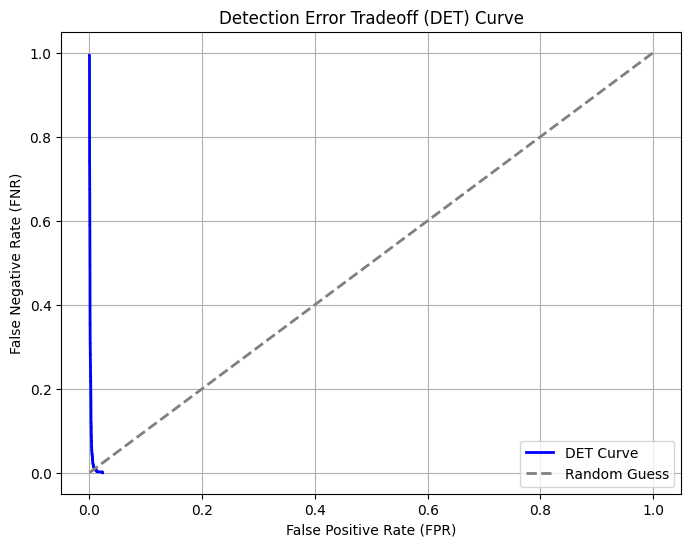

In [ ]:
scores=reconstruction_errors
# Compute the DET curve
fpr, fnr, thresholds = det_curve(merged_labels, scores)

# Plot the DET curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, fnr, color='b', lw=2, label='DET Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('Detection Error Tradeoff (DET) Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize variables
best_threshold = 0
best_f_score = 0

# Iterate over different thresholds
for threshold in np.arange(0, 1, 0.001):
    # Create predicted labels
    predicted_labels = np.zeros(len(merged_data), dtype=int)
    predicted_labels[reconstruction_errors > threshold] = 1

    # Calculate evaluation metrics
    f_score = f1_score(merged_labels, predicted_labels)

    # Check if current threshold gives a better F1-score
    if f_score > best_f_score:
        best_f_score = f_score
        best_threshold = threshold

# Use the best threshold for final predictions
predicted_labels = np.zeros(len(merged_data), dtype=int)
predicted_labels[reconstruction_errors > best_threshold] = 1

# Calculate evaluation metrics with the best threshold
accuracy = accuracy_score(merged_labels, predicted_labels)
precision = precision_score(merged_labels, predicted_labels)
recall = recall_score(merged_labels, predicted_labels)
f_score = f1_score(merged_labels, predicted_labels)

# Print the evaluation metrics with the best threshold
print("Best Threshold:", best_threshold)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", f_score)

Best Threshold: 0.17
Accuracy: 0.9961991108011508
Precision: 0.7322033898305085
Recall: 0.8780487804878049
F-score: 0.7985212569316081


Accuracy: 0.9961991108011508
Precision: 0.7322033898305085
Recall: 0.8780487804878049
F-score: 0.7985212569316081


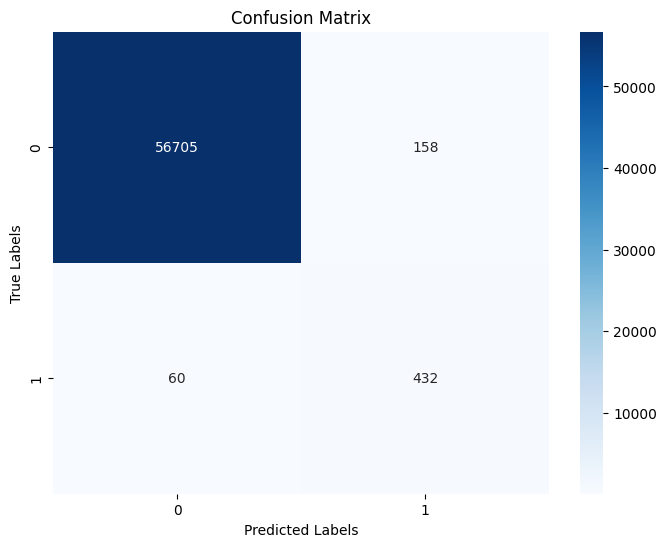

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have defined the necessary variables and thresholds

# Detect anomalies based on the threshold
threshold = 0.17
anomalies = merged_data[reconstruction_errors > threshold]

# Create predicted labels
predicted_labels = np.zeros(len(merged_data), dtype=int)
predicted_labels[reconstruction_errors > threshold] = 1

# Calculate evaluation metrics
accuracy = accuracy_score(merged_labels, predicted_labels)
precision = precision_score(merged_labels, predicted_labels)
recall = recall_score(merged_labels, predicted_labels)
f_score = f1_score(merged_labels, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", f_score)

# Create a confusion matrix
cm = confusion_matrix(merged_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()